## Домашняя работа №3

Обучить СНС с помощью Transfer Learning на датасете Food-101.
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow].

### Import modules

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import tensorflow as tf
import PIL.Image
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.__version__)

2.1.0


### Download and prepare the Food-101 dataset

In [3]:
#tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

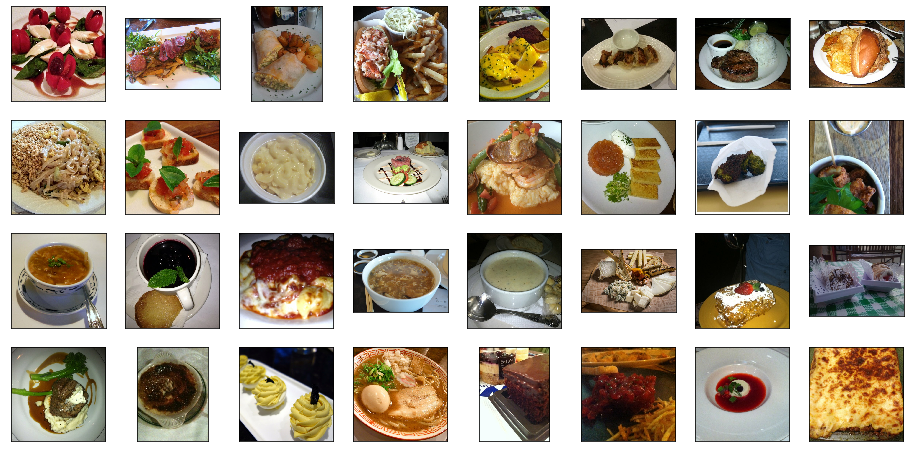

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

### Build data pipeline

In [5]:
INP_SIZE = 160
NUM_EPOCHS = 1
BATCH_SIZE = 32
NUM_EXAMPLES = 2048

#def convert(image, label):
#  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
#  return image, label

def convert(image, label):
    image = tf.cast(image, tf.float32)/127. - 1.
    return tf.image.resize(image, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(convert)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(convert)
test_ds = test_ds.batch(128, drop_remainder=True)

In [6]:
num_train_examples= ds_info.splits['train'].num_examples

In [7]:
def augment(image, label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [8]:
augmented_train_batches = (
    train_ds
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

ValueError: in converted code:

    <ipython-input-7-8b097b6693cc>:5 augment  *
        image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\ops\random_ops.py:348 random_crop
        math_ops.reduce_all(shape >= size),
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\ops\gen_math_ops.py:4080 greater_equal
        "GreaterEqual", x=x, y=y, name=name)
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:742 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\func_graph.py:595 _create_op_internal
        compute_device)
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\ops.py:3322 _create_op_internal
        op_def=op_def)
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1786 __init__
        control_input_ops)
    C:\Users\fini1\anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1622 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 4 and 3 for 'random_crop/GreaterEqual' (op: 'GreaterEqual') with input shapes: [4], [3].


### Prepare CNN model

In [ ]:
if 0: # Обучение модели с нуля

    EXP_NAME = 'scratch'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights=None,
    )
    base_model.trainable = True

else: # Transfer Learning

    EXP_NAME = 'transfer'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
    )
    base_model.trainable = True # Fine-tuning весов предобученной модели
    # base_model.trainable = False # Заморозка весов предобученной модели

In [ ]:
def make_model():
    model = tf.keras.Sequential([
        base_model, 
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid'), 
    ])
    
    LEARNING_RATE = 0.0001
    optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

### Prepare to model learning

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

In [ ]:
model.summary()

### Model learning

In [ ]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=1, validation_data=validation_batches)

In [ ]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

In [ ]:
%%time

model.evaluate(test_ds)

### TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Prediction for ready image

In [ ]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/catdog/img/image.png

img = imageio.imread('image.png', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [ ]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))